# Cogs 118C Final Project

## Anand Mysorekar, Leo Fleury, & Ava Rubin

# Loading Data

In [1]:
from scipy import io
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy import signal
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.ticker import PercentFormatter


In [2]:
# Acessing AD & control 
control_path = 'C:/Users/leofl/OneDrive/Pictures/Documents/GitHub/cogs118c-project/control_EEG_sub_037_processed.npy'
control = np.load(control_path) * 1e6
ad_path = 'C:/Users/leofl/OneDrive/Pictures/Documents/GitHub/cogs118c-project/AD_EEG_sub_001_processed.npy'
AD = np.load(ad_path) * 1e6


In [3]:
fs = 500
num_samples = control.shape[1]
duration = num_samples / fs

time = np.linspace(0, duration , num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']

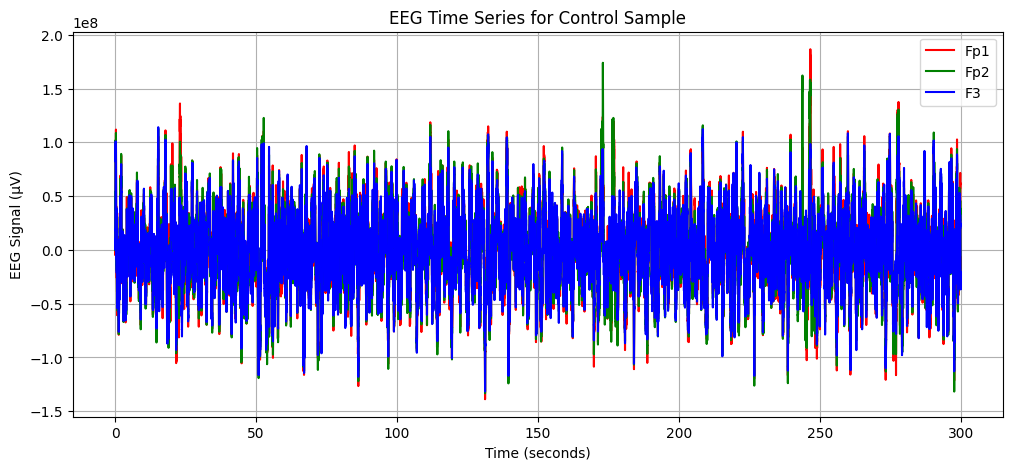

In [4]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, control[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Control Sample")
plt.legend()
plt.grid(True)

plt.show()

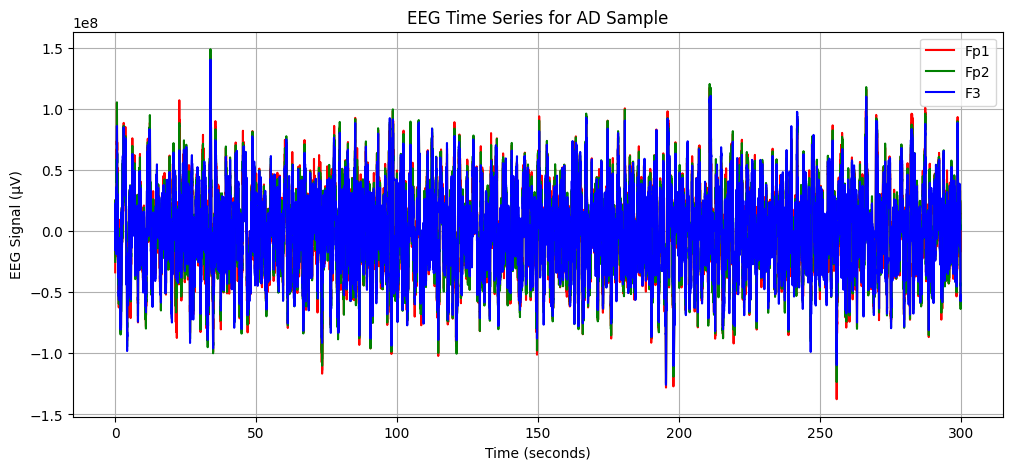

In [5]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, AD[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for AD Sample")
plt.legend()
plt.grid(True)

plt.show()

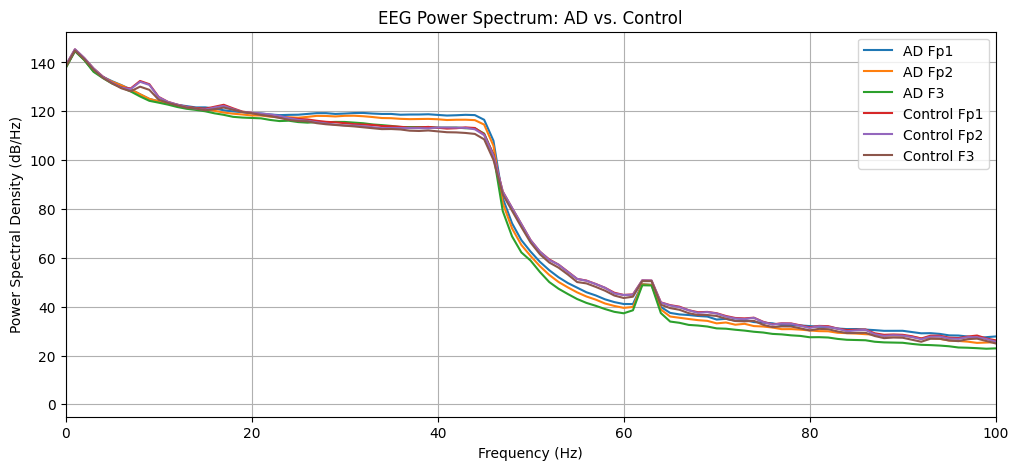

In [6]:
def plot_psd(signal, fs,condition):
    """Plots absolute power in theta/gamma bands between control and AD groups for all subjects."""
    freqs, psd = welch(signal, fs=fs, window='hann', nperseg=500, noverlap=250, scaling='density') # We use Welches
     # Convert to dB  and plot
    plt.plot(freqs, 10 * np.log10(psd), label=condition)
    plt.xlim(0, 100)  # Keep in range
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('EEG Power Spectrum: AD vs. Control')
    plt.grid(True)

# Parameters 
fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 100) # Gamma frequency range 

# Plot PSD for AD and Control groups
plt.figure(figsize=(12, 5))

# Loop through AD group
for i in range(AD.shape[0]):
    plot_psd(AD[i, :], fs, condition=f"AD {channels[i]}")

# Loop through Control group
for i in range(control.shape[0]):
    plot_psd(control[i, :], fs, condition=f"Control {channels[i]}")

plt.legend()  # Add legend to distinguish AD and Control
plt.show()

In [7]:
# bandass filtering for theta and gamma 

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 100) # Gamma frequency range

AD_filtered = []
for i in range(AD.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(AD[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(AD[i, :], gamma_band[0], gamma_band[1], fs)
    AD_filtered.append((channels[i], theta_data, gamma_data))

# Apply bandpass filtering for Control group
control_filtered = []
for i in range(control.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(control[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(control[i, :], gamma_band[0], gamma_band[1], fs)
    control_filtered.append((channels[i], theta_data, gamma_data))

In [8]:
# Compute band power using np.trapz
def compute_band_power(raw_data, fs, band, nperseg= 500):
    """Compute absolute/relative power from raw (unfiltered) data."""
    freqs, psd = welch(raw_data, fs=fs, nperseg=nperseg)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    abs_power = np.trapz(psd[idx], freqs[idx])
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies
    rel_power = abs_power / total_power
    return abs_power, rel_power

# Initialize storage for band power results
results = {
    'AD_theta_abs': [], 'AD_theta_rel': [],
    'AD_gamma_abs': [], 'AD_gamma_rel': [],
    'CTRL_theta_abs': [], 'CTRL_theta_rel': [],
    'CTRL_gamma_abs': [], 'CTRL_gamma_rel': []
}

# Process AD group using pre-filtered data
for i in range(AD.shape[0]):
    theta_abs, theta_rel = compute_band_power(AD[i, :], fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(AD[i, :], fs, gamma_band)
    results['AD_theta_abs'].append(theta_abs)
    results['AD_theta_rel'].append(theta_rel)
    results['AD_gamma_abs'].append(gamma_abs)
    results['AD_gamma_rel'].append(gamma_rel)

# Process Control group using pre-filtered data
for i in range(control.shape[0]):
    theta_abs, theta_rel = compute_band_power(control[i, :], fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(control[i,:], fs, gamma_band)
    results['CTRL_theta_abs'].append(theta_abs)
    results['CTRL_theta_rel'].append(theta_rel)
    results['CTRL_gamma_abs'].append(gamma_abs)
    results['CTRL_gamma_rel'].append(gamma_rel)

results

{'AD_theta_abs': [51951770481178.55, 50491316646560.84, 43103761414178.16],
 'AD_theta_rel': [0.08581085108237273,
  0.0843293831591688,
  0.07637447061009171],
 'AD_gamma_abs': [11414519509934.9, 7751466737177.738, 3752735953584.9395],
 'AD_gamma_rel': [0.018853825861405788,
  0.012946313384947903,
  0.006649378439168688],
 'CTRL_theta_abs': [54621822561880.02, 52790194872479.555, 45938401855017.31],
 'CTRL_theta_rel': [0.07750862942650566,
  0.07484707492199537,
  0.07367741751441655],
 'CTRL_gamma_abs': [3575911324975.77, 3254388363734.89, 2584705847506.3423],
 'CTRL_gamma_rel': [0.0050742354017132615,
  0.004614141892715733,
  0.0041454304936356795]}

AD subject: Theta = 8.22%, Gamma = 1.28%
Control subject: Theta = 7.53%, Gamma = 0.46%


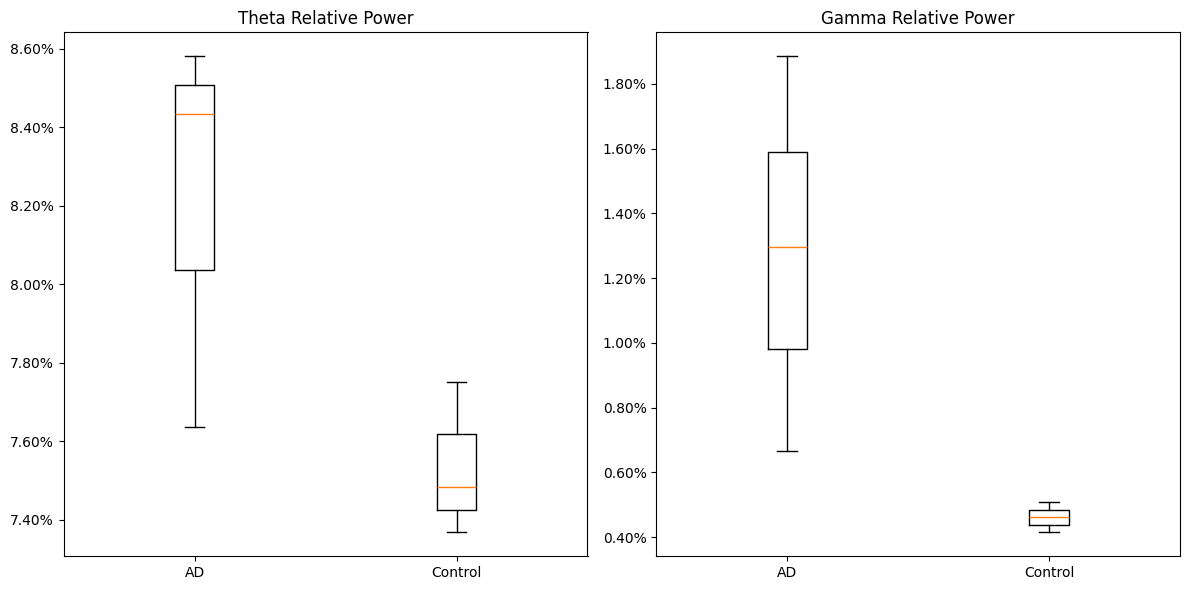

In [9]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.boxplot([results['AD_theta_rel'], results['CTRL_theta_rel']])
plt.title('Theta Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Convert to %


plt.subplot(122)
plt.boxplot([results['AD_gamma_rel'], results['CTRL_gamma_rel']])
plt.title('Gamma Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Convert to %
plt.tight_layout()

# Averaging Gamma and Theta
ad_theta_avg = np.mean(results['AD_theta_rel'])
ad_gamma_avg = np.mean(results['AD_gamma_rel'])
ctrl_theta_avg = np.mean(results['CTRL_theta_rel'])
ctrl_gamma_avg = np.mean(results['CTRL_gamma_rel'])

print(f'AD subject: Theta = {(ad_theta_avg * 100):.2f}%, Gamma = {(ad_gamma_avg * 100):.2f}%')
print(f'Control subject: Theta = {(ctrl_theta_avg * 100):.2f}%, Gamma = {(ctrl_gamma_avg * 100):.2f}%')

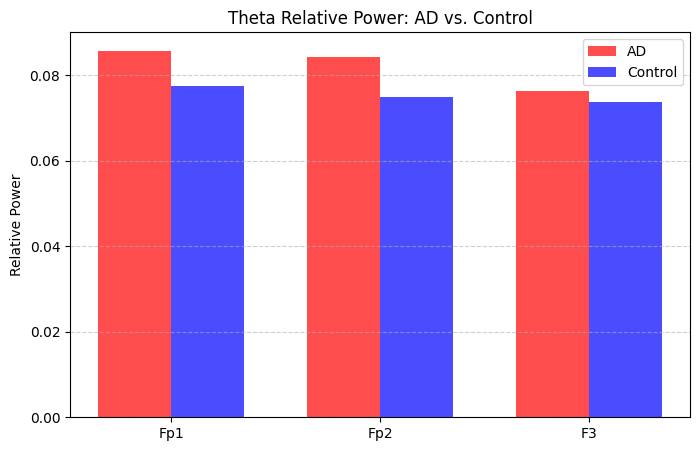

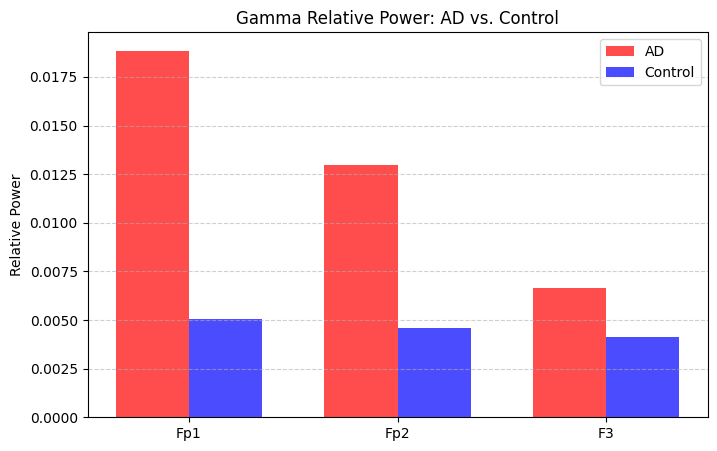

In [10]:
def plot_grouped_power(results_ad, results_ctrl, band_name):
    plt.figure(figsize=(8, 5))
    
    x = np.arange(len(channels)) 
    width = 0.35

    plt.bar(x - width/2, results_ad, width, color='red', alpha=0.7, label='AD')
    plt.bar(x + width/2, results_ctrl, width, color='blue', alpha=0.7, label='Control')

    plt.xticks(ticks=x, labels=channels)
    plt.ylabel('Relative Power')
    plt.title(f'{band_name} Relative Power: AD vs. Control')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

plot_grouped_power(results['AD_theta_rel'], results['CTRL_theta_rel'], 'Theta')
plot_grouped_power(results['AD_gamma_rel'], results['CTRL_gamma_rel'], 'Gamma')

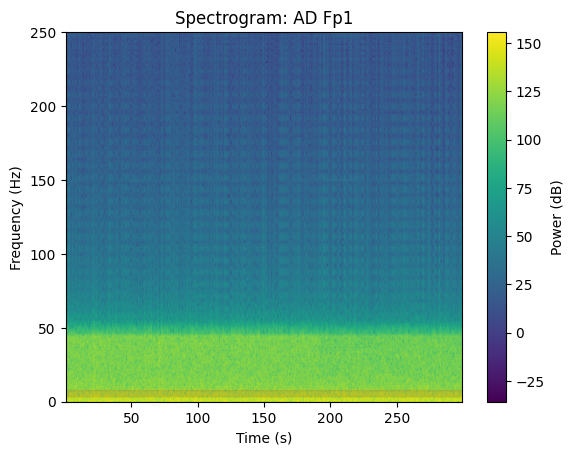

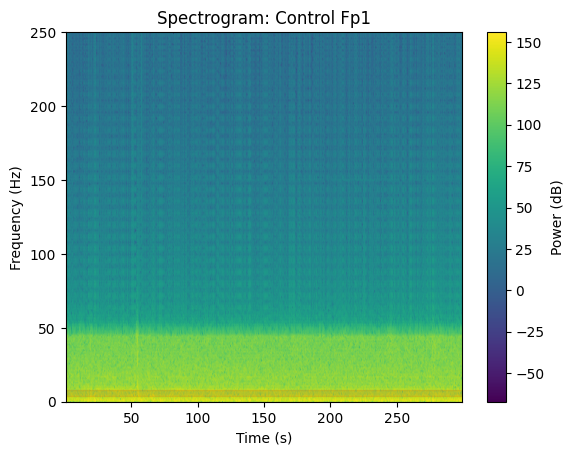

In [11]:
def plot_spectrogram(data, fs, channel_name, band=None):
    f, t, Sxx = signal.spectrogram(data, fs, nperseg=500, noverlap=250)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    if band:
        plt.axhspan(band[0], band[1], color='red', alpha=0.1)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Spectrogram: {channel_name}')
    plt.show()

# Example: Compare Fp1 in AD vs. Control
plot_spectrogram(AD[0, :], fs, 'AD Fp1', theta_band)
plot_spectrogram(control[0, :], fs, 'Control Fp1', theta_band)

In [12]:
from scipy.signal import welch

fs = 500  # Sampling rate (Hz)
nperseg = 1000  # Segment length (samples)
overlap_fraction = 0.5  # 50% overlap
noverlap = int(nperseg * overlap_fraction)  # 500 samples

freqs, psd = welch(
    data, 
    fs=fs, 
    nperseg=nperseg, 
    noverlap=noverlap, 
    window='hann'  # Hanning window (default)
)

NameError: name 'data' is not defined